# Final Project - Chow(C&P)-bigger data_CNN2021 vs TFVGG16

## Classification of COVID19 Chest X-ray via CNN (CNN2021 & TFVGG16)

### <font color=blue>By Mei, Le Ping Tan , Student ID: M00724895</font><br>


### <font color=blue>Table of contents</font>
#### 1.    Import relevant libraries<br>
#### 2.    Explore Data Set<br>
**2.1  Define the directories and Visualiz input data images / dataset**<br>
**2.2  Dataset Pre-Processing**<br>
#### 3.   Build Convolutional Neural Network (CNN2021) model<br>
**3.1  Callbacks list**<br>
**3.2  Training Files Configuration**<br>
**3.3  Fit training and validation data into CNN2021 model**<br>
**3.4  Evaluation of CNN2021 model**<br>
**3.4.1 Model's Results**<br>
**3.4.2 Confusion Matrix of CNN2021**<br>
**3.4.3 Classification Report of CNN2021**<br>
#### 4.    Build Transfer Learning (TFVGG16) model<br>
**4.1  Fit training and validation data into VGG16 model**<br>
**4.2 Evaluation of CNN model**<br>
**4.2.1 Model's Results**<br>
**4.2.2 Confusion Matrix of TFVGG16**<br>
**4.2.3 Classification Report of TFVGG16**<br>
<br>
<br>
<br>
<br>

## 1.  Import the relevant libraries

In [27]:
import os
import re
import cv2
import keras
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Activation, BatchNormalization
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications import VGG19
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

## 2.  Explore Data Set

### 2.1  Define the directories and Visualiz input data images / dataset

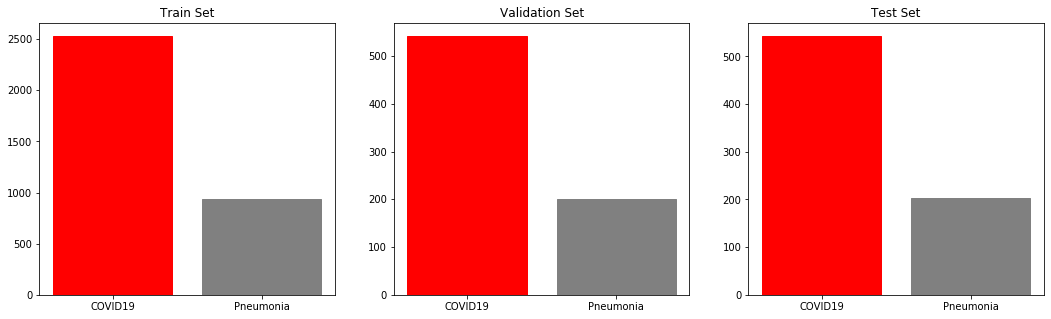

train set: COVID19 images: 2531, Pneumonia: 941
val set: COVID19 images: 542, Pneumonia: 201
test set: COVID19 images: 543, Pneumonia: 203


In [28]:
#Define the dataset directory
train_path = 'dataset(C&P)/train'
test_path = 'dataset(C&P)/test'
val_path = 'dataset(C&P)/val'

x = ["COVID19", "Pneumonia"]

y1 = [len(os.listdir(train_path + "/COVID")), len(os.listdir(train_path + "/Pneumonia"))]
y2 = [len(os.listdir(val_path + "/COVID")), len(os.listdir(val_path + "/Pneumonia"))]
y3 = [len(os.listdir(test_path + "/COVID")), len(os.listdir(test_path + "/Pneumonia"))]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
ax1.bar(x=np.arange(len(x)), height=y1, width=0.8, color=["red", "grey"], edgecolor=["red", "grey"])
ax1.set_title("Train Set")
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x)

ax2.bar(x=np.arange(len(x)), height=y2, width=0.8, color=["red", "grey"], edgecolor=["red", "grey"])
ax2.set_title("Validation Set")
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x)

ax3.bar(x=np.arange(len(x)), height=y3, width=0.8, color=["red", "grey"], edgecolor=["red", "grey"])
ax3.set_title("Test Set")
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x)

plt.show()

#Count the images in each path of dataset
input_path='dataset(C&P)/'
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    
    n_covid = len(os.listdir(input_path + _set + '/COVID'))
    n_normal = len(os.listdir(input_path + _set + '/Pneumonia'))
    
    print('{} set: COVID19 images: {}, Pneumonia: {}'.format(_set, n_covid, n_normal))

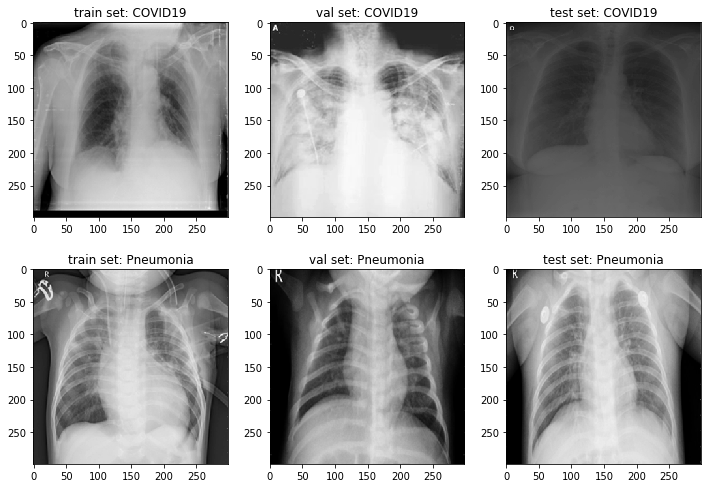

In [29]:
#Visualise imaging of each path of dataset
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set

    ax[i].imshow(plt.imread(set_path+'/COVID/'+os.listdir(set_path+'/COVID')[9]), cmap='gray')
    ax[i].set_title('{} set: COVID19'.format(_set))
    
    ax[i+3].imshow(plt.imread(set_path+'/Pneumonia/'+os.listdir(set_path+'/Pneumonia')[9]), cmap='gray')
    ax[i+3].set_title('{} set: Pneumonia'.format(_set))
    

### 2.2  Dataset Pre- Processing

#### Reshape dataset & Load images using ImageDataGenerator

In [30]:
#Batch refers to the number of training examples utilized in one #iteration
batch_size = 32 

#The dimension of the images size set as 224X224
img_height = 224
img_width = 224

# Random seed is set to be 79 to which will be use to replicate the same data result each time , so the output will be same when run the program eacg time
np.random.seed(79)


# Generate data from directory -data/train, val and test and then reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary')

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary')

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary', shuffle=False)
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 



Found 3472 images belonging to 2 classes.
Found 743 images belonging to 2 classes.
Found 746 images belonging to 2 classes.


## 3.  Build Convolutional Neural Network (CNN2021) model

A cnn model called CNN2021 will be build from 5 conv layers with max pooling and later connected to Fully connected layers with two dense layers and lastly connected to the output fully connected  layer of one neuron.

The design of the conv layers filters has been increasing from 32 to 64 to 128 to 256. First layer start with 32 layers and increased according. Second and third layers are with the same number of filters which is 64. Followed by fourth layer 128 layers and lastly 256 layers. In addition, the Maxpooling are same for all the 5 layers which is 2 x 2 indicating the reduction of image size, eg. the input of 224X 224 will be reduce to 112x112 and so on after each layer.The architecture of this CNN2021 model is with numbers of feature/ filters increasing for the feature map, inversley the image size are decreasing.

In [31]:
#CNN2021 Model for below coding
cnn2021 = Sequential()

# 1st Conv layer with filters=32,3 x 3 window & Max Pooling layer with 2 x 2 window
cnn2021.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn2021.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Conv layer with filter =32, 3 x 3 window & Max Pooling layer with window 2 x 2 window
cnn2021.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn2021.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Conv layer with filters=64,3 x 3 window & Max Pooling layer with window 2 x 2
cnn2021.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn2021.add(MaxPooling2D(pool_size = (2, 2)))

# 4th Conv layer with filters=64,3 x 3 window & Max Pooling layer with window 2 x 2
cnn2021.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn2021.add(MaxPooling2D(pool_size = (2, 2)))

# 5th Conv layer with filters=128,3 x 3 window & Max Pooling layer with window 2 x 2
cnn2021.add(Conv2D(256, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn2021.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten layer
cnn2021.add(Flatten())

# Fully Connected Layers with 2 dense layers of 128 and 64 neurons
#cnn2021.add(Dense(activation = 'relu', units = 128))
cnn2021.add(Dense(activation = 'relu', units = 64))
cnn2021.add(Dropout(0.5))
#cnn2021.add(Dense(activation = 'relu', units = 64))

#Single output layer with one neuron to predict binary classification
cnn2021.add(Dense(activation = 'sigmoid', units = 1))


# Compile the Cov Neural network
cnn2021.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn2021.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

### 3.1  Callbacks list

Defining the parameter of EarlyStopping is called to stop the epochs based on the condition set and  monitor metrics some metric(monitor). This condition is to avoid overfitting the model build. 

The callback list is define to stop epochs based on the validation loss(val_loss) metric by minimising it.Patience = 3 meaning that when the minimum validation loss has been achieved and continue to rise in the next 3 iteration. The the training of model will stop at the epochs.

Reducing rate is implement when the metric is stop improving. Train model usually benefit from the learning rate by factor of 2-10 once it happen learning stagnates. 

The callback list is monitoring the training of model iteration when there is no more improvement afetr a patience number of epochs with the learning rate reduced.

In [32]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

cbl = [early, learning_rate_reduction]

### 3.2 Training Files Configuration

#### Assigning Class Weights


It is a good opions to assign class weights to balance the classes to ensure the model is train with equally classes.

In [33]:

weights = compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)
cw = dict(zip( np.unique(train_gen.classes), weights))
print(cw)

{0: 0.6858949032003161, 1: 1.844845908607864}


The parameters passed into cnn2021.fit are train data, epochs as 20, validation data used to calculate val_loss and val_accuracy , class weights and callback list.

### 3.3  Fit training and validation data into CNN2021 model

In [34]:
start = datetime.datetime.now()
#print(start)

cnn2021_history = cnn2021.fit(train_gen,epochs=20, validation_data=val_gen, class_weight=cw, callbacks=cbl)

end = datetime.datetime.now()
elapsed = end - start
print(' Total Time to fit CNN2021 model is:\n {}'.format(elapsed))

Epoch 1/20
109/109 [==============================] - 377s 3s/step - loss: 0.6085 - accuracy: 0.6107 - val_loss: 0.2367 - val_accuracy: 0.9152
Epoch 2/20
109/109 [==============================] - 357s 3s/step - loss: 0.2124 - accuracy: 0.9299 - val_loss: 0.1107 - val_accuracy: 0.9583
Epoch 3/20
109/109 [==============================] - 350s 3s/step - loss: 0.1216 - accuracy: 0.9720 - val_loss: 0.0936 - val_accuracy: 0.9610
Epoch 4/20
109/109 [==============================] - 344s 3s/step - loss: 0.1181 - accuracy: 0.9756 - val_loss: 0.0785 - val_accuracy: 0.9744
Epoch 5/20
109/109 [==============================] - 343s 3s/step - loss: 0.0752 - accuracy: 0.9809 - val_loss: 0.0788 - val_accuracy: 0.9677
Epoch 6/20
109/109 [==============================] - 339s 3s/step - loss: 0.0711 - accuracy: 0.9762 - val_loss: 0.0771 - val_accuracy: 0.9744
Epoch 7/20
109/109 [==============================] - 343s 3s/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0639 - val_accuracy: 0.9785

Looks like the EarlyStopping stopped at 13th epoch at val_loss = 4.89% and val_accuracy = 95.91%.


### 3.4  Evaluation of CNN2021 model

In [35]:
#Train set
train_loss, train_acc = cnn2021.evaluate_generator(train_gen)

print('Train accuracy:', train_acc*100, '%')
print('Train loss:',train_loss*100, '%')

#Val set
val_loss, val_acc = cnn2021.evaluate_generator(val_gen)

print('Validation accuracy:', val_acc*100, '%')
print('Validation loss:',val_loss*100, '%')

#Test set
test_loss, test_acc = cnn2021.evaluate(test_gen)

print('Test accuracy:', test_acc*100, '%')
print('Test loss:',test_loss*100, '%')

C:\Users\meita\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train accuracy: 99.82718825340271 %
Train loss: 0.3837608499452472 %
Validation accuracy: 98.92328381538391 %
Validation loss: 4.375489056110382 %
24/24 [==============================] - 27s 1s/step - loss: 0.0600 - accuracy: 0.9866
Test accuracy: 98.65951538085938 %
Test loss: 5.99667988717556 %


### 3.4.1 Model's Results

In [36]:
# Create a model's dictionaries
def store_outcomes_to_dict(model_desc, elapsed, train_acc,train_loss,val_acc,val_loss, test_acc, test_loss):
    model_dict = {'Model Description':model_desc
                 ,'Elapsed Time':elapsed
                 ,'Training Accuracy': train_acc
                 ,'Training Loss': train_loss
                 ,'Validation Accuracy':val_acc
                 ,'validation Loss':val_loss
                 ,'Testing Accuracy':test_acc
                 ,'Testing Loss':test_loss
                  
                }
    return model_dict
# Store the results of all models
outcomes = []

In [37]:
# Create outcomes of cnn model

outcomes=store_outcomes_to_dict('CNN2021 Model', elapsed, train_acc,train_loss,val_acc,val_loss, test_acc, test_loss)

outcomes

{'Model Description': 'CNN2021 Model',
 'Elapsed Time': datetime.timedelta(seconds=6973, microseconds=383172),
 'Training Accuracy': 0.9982718825340271,
 'Training Loss': 0.0038376084994524717,
 'Validation Accuracy': 0.9892328381538391,
 'validation Loss': 0.04375489056110382,
 'Testing Accuracy': 0.9865951538085938,
 'Testing Loss': 0.0599667988717556}

In [38]:
# append outcomes of the  model
outcomes_final = []
outcomes_final.append(outcomes)

# Showing outcomes in dataframe
df_model_outcomes = pd.DataFrame(outcomes_final)
df_model_outcomes

,Model Description,Elapsed Time,Training Accuracy,Training Loss,Validation Accuracy,validation Loss,Testing Accuracy,Testing Loss
0,CNN2021 Model,01:56:13.383172,0.998272,0.003838,0.989233,0.043755,0.986595,0.059967


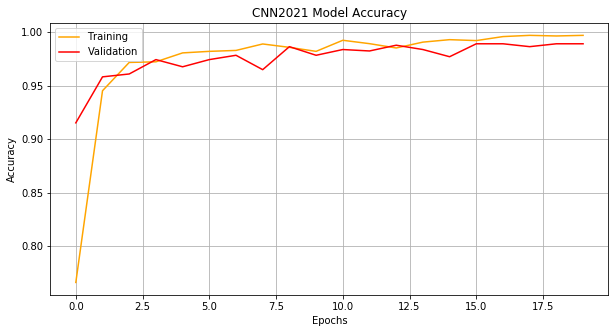

<Figure size 432x288 with 0 Axes>

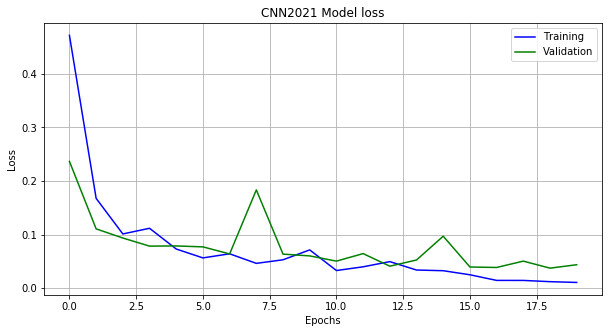

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline 


acc = cnn2021_history.history['accuracy']
val_acc = cnn2021_history.history['val_accuracy']
loss = cnn2021_history.history['loss']
val_loss = cnn2021_history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(epochs, acc, 'b',  color='orange', label='Training')
plt.plot(epochs, val_acc, 'b',  color='red', label='Validation')
plt.title('CNN2021 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(epochs, loss, 'b', color='blue', label='Training')
plt.plot(epochs, val_loss, 'b', color='green', label='Validation')
plt.title('CNN2021 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### 3.4.2 Confusion Matrix of CNN2021

24/24 [==============================] - 21s 838ms/step
   Confusion Matrix Heatmap for CNN2021 Model


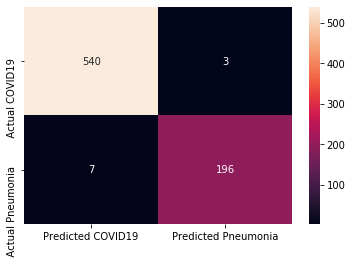

In [40]:
# Prediction on test dataset 
preds = cnn2021.predict(test_gen,verbose=1)
#Since the activation function of the last layer is sigmoid, 
#the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. 
#So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. 
#Note(0 denotes a COVID19 case and 1 denotes a case of Normal)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1


cfm = pd.DataFrame(data=confusion_matrix(test_gen.classes, predictions, labels=[0, 1]),index=["   Actual COVID19", "   Actual Pneumonia"],
columns=["Predicted COVID19", "Predicted Pneumonia"])

sns.heatmap(cfm,annot=True,fmt="d")

print('   Confusion Matrix Heatmap for CNN2021 Model' )

### 3.4.3 Classification Report of CNN2021

In [41]:
print ('              Classification Report for CNN2021 Model')
print ('              ---------------------------------------')
print(classification_report(y_true=test_gen.classes,y_pred=predictions,target_names =['COVID19','Pneumonia']))

              Classification Report for CNN2021 Model
              ---------------------------------------
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       543
   Pneumonia       0.98      0.97      0.98       203

    accuracy                           0.99       746
   macro avg       0.99      0.98      0.98       746
weighted avg       0.99      0.99      0.99       746



In [42]:
# saving model name and end time of the model
cnn2021.save('CNN2021 2FC (C&P) Model.h5')


## 4.   Build Transfer Learning VGG16 (TFVGG16) model

Pre trained VGG-16 model's achitecture will be used to train this model(TFVGG16- 15 layers).This model will consist of two sections which is the convolutional base (13 layers) which is identify the features of data and then connected to the fully connected neaural network base (2 Fully Connected layers)classifying the data based on the feature. 

This pretrained model VGG16 is used to train the feature and then connected to one fully connected hidden layer and then one output layer to classify the input data images based on features trained of vGG16. Pretrained weight used is Imagenet.

In [43]:
np.random.seed(79)

# Generate data from directory -data/train, val and test and then reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary')

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary')

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
        target_size=(img_height, img_width), batch_size=batch_size,class_mode = 'binary', shuffle=False)
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 


Found 3472 images belonging to 2 classes.
Found 743 images belonging to 2 classes.
Found 746 images belonging to 2 classes.


In [44]:
from tensorflow.keras.applications.vgg16 import VGG16

# TFVGG16, the second model built from Transfer learning = vgg16 as below coding
# add preprocessing layer to the front of VGG16
tfvgg16 = VGG16(weights='imagenet',#imagenet is the final weight of vgg16 
                  include_top=False, #meaning import only the conv base not the whole thing
                  input_shape=(img_width, img_height,3))

#don't train existing weights to avoid overfitting
for layer in tfvgg16.layers:
    layer.trainable = False
    
tfvgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Do not need to optimize weight in this tf_model as it has optimized by imagnet. Next step:adding fully connected dense layer and output layer infront of this vgg16.


In [45]:
tfvgg16_model=models.Sequential()
tfvgg16_model.add(tfvgg16) #adding conv_base that was imported

# Flatten layer
tfvgg16_model.add(layers.Flatten())

# Fully Connected Layers with one dense layer of 64 neurons

tfvgg16_model.add(Dense(activation = 'relu', units = 64))

tfvgg16_model.add(Dropout(0.5))


#Single output layer with one neuron to predict binary classification
#The sigmoid function is used for the two-class logistic regression, whereas the softmax function is used for the multiclass logistic regression 

tfvgg16_model.add(Dense(activation = 'sigmoid', units = 1))

tfvgg16_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


tfvgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,320,449
Trainable params: 1,605,761
Non-trainable params: 14,714,688
_________________________________________________________________


## 4.1  Fit training and validation data into TFVGG16 model<br>

In [46]:
tfvgg16_start = datetime.datetime.now()


tfvgg16_history = tfvgg16_model.fit(train_gen,epochs=3, validation_data=val_gen, class_weight=cw, callbacks=cbl)

tfvgg16_end = datetime.datetime.now()
tfvgg16_elapsed = tfvgg16_end - tfvgg16_start
print(' Total Time to fit Transfer Learning VGG16 model is:\n {}'.format(tfvgg16_elapsed))

Epoch 1/3
109/109 [==============================] - 2281s 21s/step - loss: 0.5386 - accuracy: 0.8144 - val_loss: 0.0467 - val_accuracy: 0.9879
Epoch 2/3
109/109 [==============================] - 2261s 21s/step - loss: 0.0727 - accuracy: 0.9773 - val_loss: 0.0369 - val_accuracy: 0.9892
Epoch 3/3
109/109 [==============================] - 2259s 21s/step - loss: 0.0590 - accuracy: 0.9893 - val_loss: 0.0458 - val_accuracy: 0.9892
 Total Time to fit Transfer Learning VGG16 model is:
 1:53:21.379877


## 4.2 Evaluation of TFVGG16 model<br>


In [47]:
train_loss, train_acc = tfvgg16_model.evaluate_generator(train_gen)

print('Train accuracy:', train_acc*100, '%')
print('Train loss:',train_loss*100, '%')

val_loss, val_acc = tfvgg16_model.evaluate_generator(val_gen)

print('Validation accuracy:', val_acc*100, '%')
print('Validation loss:',val_loss*100, '%')

test_loss, test_acc = tfvgg16_model.evaluate(test_gen)

print('Test accuracy:', test_acc*100, '%')
print('Test loss:',test_loss*100, '%')

C:\Users\meita\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train accuracy: 99.42396283149719 %
Train loss: 2.170353941619396 %
Validation accuracy: 98.92328381538391 %
Validation loss: 4.577601328492165 %
24/24 [==============================] - 417s 17s/step - loss: 0.0499 - accuracy: 0.9879
Test accuracy: 98.79356622695923 %
Test loss: 4.987316206097603 %


### 4.2.1 Model's Results<br>

In [48]:
# call for the fuction outcomes of tfvgg16

outcomes=store_outcomes_to_dict('TFVGG16', tfvgg16_elapsed, train_acc,train_loss,val_acc,val_loss, test_acc, test_loss)

outcomes

# append outcomes of the tfvgg16

outcomes_final.append(outcomes)

# Showing outcomes in dataframe
df_model_outcomes = pd.DataFrame(outcomes_final)
df_model_outcomes

,Model Description,Elapsed Time,Training Accuracy,Training Loss,Validation Accuracy,validation Loss,Testing Accuracy,Testing Loss
0,CNN2021 Model,01:56:13.383172,0.998272,0.003838,0.989233,0.043755,0.986595,0.059967
1,TFVGG16,01:53:21.379877,0.994240,0.021704,0.989233,0.045776,0.987936,0.049873


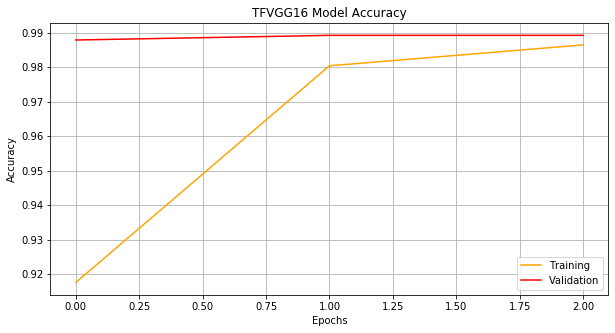

<Figure size 432x288 with 0 Axes>

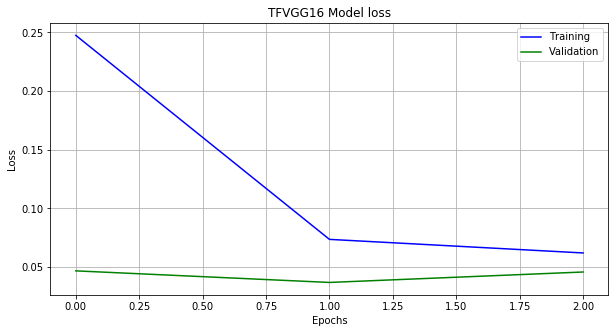

In [49]:
acc = tfvgg16_history.history['accuracy']
val_acc = tfvgg16_history.history['val_accuracy']
loss = tfvgg16_history.history['loss']
val_loss = tfvgg16_history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(epochs, acc, 'b',  color='orange', label='Training')
plt.plot(epochs, val_acc, 'b',  color='red', label='Validation')
plt.title('TFVGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(epochs, loss, 'b', color='blue', label='Training')
plt.plot(epochs, val_loss, 'b', color='green', label='Validation')
plt.title('TFVGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### 4.2.2 Confusion Matrix of TFVGG16<br>

24/24 [==============================] - 385s 16s/step
   Confusion Matrix Heatmap for TFVGG16 Model


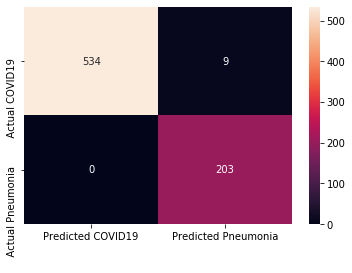

In [50]:
tfvgg16_preds = tfvgg16_model.predict(test_gen,verbose=1)

#Since the activation function of the last layer is sigmoid, 
#the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. 
#So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. 
#Note(0 denotes a COVID19 case and 1 denotes a case of Pneumonia)
predictions = tfvgg16_preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

cfm = pd.DataFrame(data=confusion_matrix(test_gen.classes, predictions, labels=[0, 1]),index=["   Actual COVID19", "   Actual Pneumonia"],
columns=["Predicted COVID19", "Predicted Pneumonia"])

sns.heatmap(cfm,annot=True,fmt="d")

print('   Confusion Matrix Heatmap for TFVGG16 Model' )

### 4.2.3 Classification Report of TFVGG16<br>

In [51]:
print ('              Classification Report for TFVGG16 Model')
print ('              ---------------------------------------')
print(classification_report(y_true=test_gen.classes,y_pred=predictions,target_names =['COVID19','Pneumonia']))

              Classification Report for TFVGG16 Model
              ---------------------------------------
              precision    recall  f1-score   support

     COVID19       1.00      0.98      0.99       543
   Pneumonia       0.96      1.00      0.98       203

    accuracy                           0.99       746
   macro avg       0.98      0.99      0.98       746
weighted avg       0.99      0.99      0.99       746



In [52]:
# saving model name and end time of the model
tfvgg16_model.save('TFVGG16 2FC (C&P) Model.h5')
